In [1]:
import torch
import matplotlib.pyplot as plt
torch.__version__

'2.2.0+cu121'

In [2]:
# 预定一个已知的结果
weight = 0.4
bias = 1.2

In [3]:
# 创建数据集
start = 0.5
end = 20.
step = .3

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias
X, Y

(tensor([[ 0.5000],
         [ 0.8000],
         [ 1.1000],
         [ 1.4000],
         [ 1.7000],
         [ 2.0000],
         [ 2.3000],
         [ 2.6000],
         [ 2.9000],
         [ 3.2000],
         [ 3.5000],
         [ 3.8000],
         [ 4.1000],
         [ 4.4000],
         [ 4.7000],
         [ 5.0000],
         [ 5.3000],
         [ 5.6000],
         [ 5.9000],
         [ 6.2000],
         [ 6.5000],
         [ 6.8000],
         [ 7.1000],
         [ 7.4000],
         [ 7.7000],
         [ 8.0000],
         [ 8.3000],
         [ 8.6000],
         [ 8.9000],
         [ 9.2000],
         [ 9.5000],
         [ 9.8000],
         [10.1000],
         [10.4000],
         [10.7000],
         [11.0000],
         [11.3000],
         [11.6000],
         [11.9000],
         [12.2000],
         [12.5000],
         [12.8000],
         [13.1000],
         [13.4000],
         [13.7000],
         [14.0000],
         [14.3000],
         [14.6000],
         [14.9000],
         [15.2000],


In [4]:
# 把数据分割为 训练，验证和测试集
train_slpite = int(.8 * len(X))
X_train, Y_train = X[:train_slpite], Y[:train_slpite]
X_test, Y_test = X[train_slpite:], Y[train_slpite:]
len(X), len(X_test), len(X_train)

(65, 13, 52)

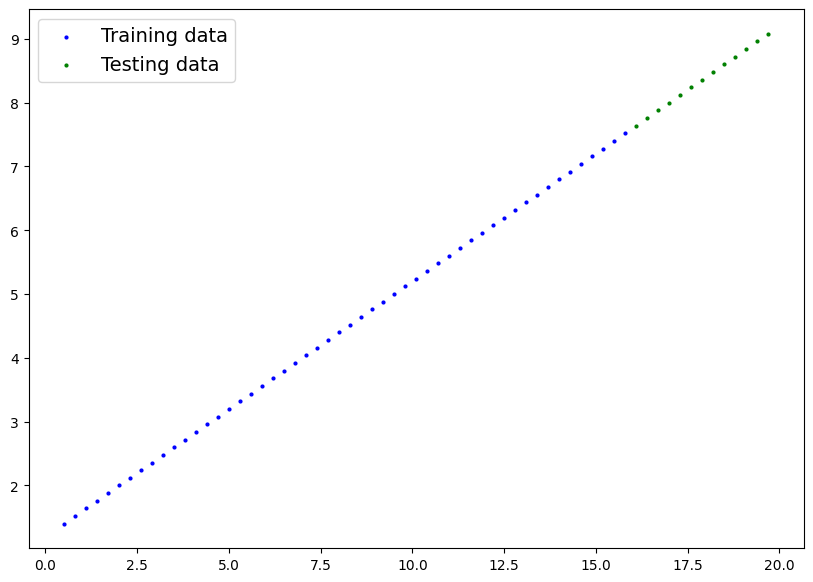

In [5]:
# 创建可视化图表
def plot_predictions(train_data=X_train, 
                     train_labels=Y_train, 
                     test_data=X_test, 
                     test_labels=Y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

plot_predictions()

In [6]:
# 创建一个线性的模型
from torch import nn

class LinerModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(size=[1], dtype=torch.float32),requires_grad=True)
        self.bias = nn.Parameter(torch.rand (size=[1], dtype=torch.float),requires_grad=True)
    
    def forward(self, _x: torch.Tensor) -> torch.Tensor:
        return _x*self.weight + self.bias

# 控释随机初始状态
torch.manual_seed(99)

LM = LinerModel()
list(LM.parameters())

[Parameter containing:
 tensor([0.1033], requires_grad=True),
 Parameter containing:
 tensor([0.9702], requires_grad=True)]

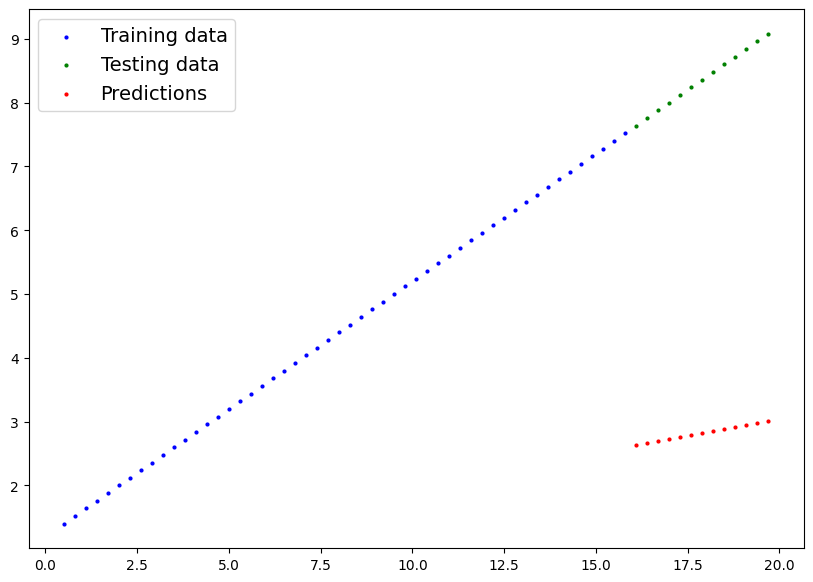

In [7]:
# 尝试用模型进行推理
with torch.inference_mode():
    y_pre = LM(X_test)
plot_predictions(predictions=y_pre)

训练模型，就是让程序试图自行从随机初始参数找到准确的参数
使用pytorch创建损失函数（loss function）和优化器（optimizer）
|-|作用|在pytorch里的位置|常用|
|---|---|---|---|
|损失函数|量化预计值和结果间的差异,越小越好|torch.nn|对于回归问题：<br/>平均绝对值误差[torch.nn.L1Loss()](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)<br/>对于二元分类：<br/>二元交叉熵[torch.optim.Adam()](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)|
|优化器|告诉模型如何更好的降低损失|torch.optim|随机梯度下降：[torch.optim.SGD()](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)<br/>Adam：[torch.optim.Adam()](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)|

In [8]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=LM.parameters(), lr=0.0001)

epochs = 10000

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    # 设置模型为训练模式
    LM.train()
    # 推理
    y_pred = LM(X_train)
    # 计算损失
    loss = loss_fn(y_pred, Y_train)
    # 梯度置零
    optimizer.zero_grad()
    # 反向传播计算梯度
    loss.backward()
    # 执行优化器
    optimizer.step()
    # 设置模型为评估模式
    LM.eval()
    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = LM(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, Y_test) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 500 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 2.6478703022003174 | MAE Test Loss: 5.525912284851074 
Epoch: 500 | MAE Train Loss: 0.07493671029806137 | MAE Test Loss: 0.1093592643737793 
Epoch: 1000 | MAE Train Loss: 0.06694231182336807 | MAE Test Loss: 0.09759954363107681 
Epoch: 1500 | MAE Train Loss: 0.05894574895501137 | MAE Test Loss: 0.0858398973941803 
Epoch: 2000 | MAE Train Loss: 0.05094919726252556 | MAE Test Loss: 0.07408006489276886 
Epoch: 2500 | MAE Train Loss: 0.04295263811945915 | MAE Test Loss: 0.06232059746980667 
Epoch: 3000 | MAE Train Loss: 0.03495655581355095 | MAE Test Loss: 0.05134248733520508 
Epoch: 3500 | MAE Train Loss: 0.026962995529174805 | MAE Test Loss: 0.03958284109830856 
Epoch: 4000 | MAE Train Loss: 0.018969446420669556 | MAE Test Loss: 0.02782319113612175 
Epoch: 4500 | MAE Train Loss: 0.010973254218697548 | MAE Test Loss: 0.01606343314051628 
Epoch: 5000 | MAE Train Loss: 0.0035900932271033525 | MAE Test Loss: 0.002007007598876953 
Epoch: 5500 | MAE Train Loss: 0.005

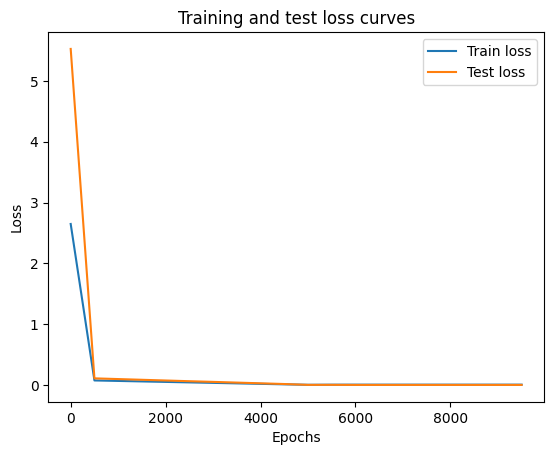

In [9]:
# 绘制学习曲线
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

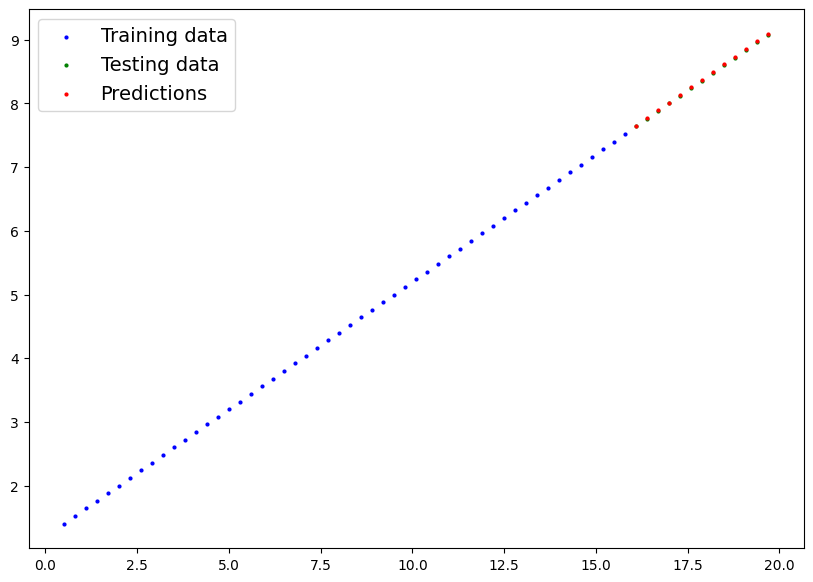

In [10]:
with torch.inference_mode():
    y_pred = LM(X_test)
plot_predictions(predictions=y_pred)

In [11]:
LM.state_dict()

OrderedDict([('weight', tensor([0.4008])), ('bias', tensor([1.1996]))])

In [15]:
# 保存和加载模型
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "liner_models.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving models into: {MODEL_SAVE_PATH}")
torch.save(obj=LM.state_dict(), f=MODEL_SAVE_PATH)

Saving models into models/liner_models.pth


In [18]:
# Check the saved file path
!ls -l models/*.pth

-rw-r--r-- 1 yhw yhw 1526 Feb 21 14:47 models/liner_models.pth


In [23]:
# 从文件加载
load_models = LinerModel()
load_models.load_state_dict(torch.load(MODEL_SAVE_PATH))
list(load_models.parameters())

[Parameter containing:
 tensor([0.4008], requires_grad=True),
 Parameter containing:
 tensor([1.1996], requires_grad=True)]